In [41]:
import torch
import torch.nn as nn
import torch.optim as Adam
import numpy as np
from collections import namedtuple
from itertools import count

# Hyperparameters
LEARNING_RATE = 0.01  # Learning rate for the nn optimizer
GAMMA = 0.997  # Discount factor
NUM_EPISODES = 1000  # Number of training episodes
eps = np.finfo(np.float32).eps.item()  # Small epsilon value to prevent division by zero

num_state = env.observation_space.shape[0]  # Dimensionality of the environment space
action_shape = env.action_space.shape[0]  # Dimensionality of the continuous environment space
action_low = env.action_space.low  # Lower bound of actions
action_high = env.action_space.high  # Upper bound of actions

class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.fc1 = nn.Linear(num_state, 128)
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with a dropout probability of 0.5
        self.mean = nn.Linear(64, action_shape)
        self.std = nn.Linear(64, action_shape)  # Allows policy to explore within the normal distribution defined by the mean and std
        self.expected_return = nn.Linear(64, 1)  # Estimate of the expected return by following the current policy
        self.action_values = []  # Lists to store actions and rewards during training
        self.rewards = []
        self.gamma = GAMMA  # Discount factor for future rewards

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))  # Pass input through the first layer and apply ReLU activation
        x = self.dropout(x)  # Apply dropout after the first layer
        x = nn.functional.relu(self.fc2(x))  # Pass through the second layer and apply ReLU activation
        x = self.dropout(x)  # Apply dropout after the second layer
        mean = torch.tanh(self.mean(x))  # Output the mean of the action distribution (squashes the output to be between -1 and 1)
        std = torch.exp(self.std(x))  # Output the standard deviation of the action distribution
        expected_return = self.expected_return(x)  # Output the state value
        return mean, std, expected_return

# Initialize the policy network
policy = Module()
# Initialize the optimizer
optimizer = Adam.Adam(policy.parameters(), lr=LEARNING_RATE)
# Named tuple to save actions and their log probabilities
saveAction = namedtuple('SavedActions', ['log_prob', 'expected_return'])



def select_action(state):

    state = torch.from_numpy(state).float()  # Convert the state to a PyTorch tensor
    mean, std, expected_return = policy(state)  # Pass the current state through the policy network and get mean, std, and expected return
    c = Normal(mean, std)  # Create a normal distribution with the mean and standard deviation
    action = c.sample()  # Sample an action from the normal distribution
    log_prob = c.log_prob(action).sum(dim=-1)  # Calculate the log probability of the sampled action
    policy.action_values.append(saveAction(log_prob, expected_return))  # Save the log probability and expected return
    
    return action.detach().numpy()  # Detach the action and convert it to a NumPy array



def finish_episode():
    rewards = []
    saved_actions = policy.action_values  # Get saved actions and their log probabilities
    
    # Calculate discounted rewards
    R = 0
    for r in policy.rewards[::-1]:  # Iterate over rewards in reverse order
        R = r + policy.gamma * R  # Apply discount factor gamma
        rewards.insert(0, R)  # Insert discounted reward at the beginning of the list

    rewards = torch.tensor(rewards)  # Convert rewards list to a PyTorch tensor
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)  # Normalize rewards
    
    policy_loss = []
    value_loss = []
    
    # Calculate policy and expected return losses
    for (log_prob, expected_return), reward in zip(saved_actions, rewards):
        advantage = r - expected_return.item()  # Calculate advantage
        policy_loss.append(-log_prob * advantage)  # Policy loss: negative log probability multiplied by advantage
        value_loss.append(nn.functional.smooth_l1_loss(expected_return, torch.tensor([reward])))  # Value loss: smooth L1 loss between expected return and discounted reward
    


    optimizer.zero_grad()  # Zero out gradients
    loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()  # Total loss
    loss.backward()  # Backpropagate the total loss
    torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1)
    optimizer.step()  # Update the optimizer parameters


    del policy.rewards[:]  # Clear rewards list for the next episode
    del policy.action_values[:]  # Clear action values list for the next episode


def train():
    run_steps = []
    for i_episode in range(NUM_EPISODES):
        state, _ = env.reset()  # Reset environment and get initial state
        for t in count():
            action = select_action(state)  # Select an action based on the current state
            next_state, reward, done, _, _ = env.step(action)  # Take action and observe next state and reward
            reward = next_state[0] + reward  # Modify reward if needed
            policy.rewards.append(reward)  # Store reward in the policy
            state = next_state  # Update current state to next state
            
            if done:
                run_steps.append(t)  # Record number of steps taken in the episode
                print("Episode {}, reward is {}".format(i_episode + 1, reward))  # Print episode number and final reward
                break
        
        finish_episode()  # Perform policy update at the end of the episode
    
    print("Training finished.")  # Print message when training completes

train()  # Start training process


train()


Episode 1, reward is 100.40547127893348
Episode 2, reward is 100.45180623057408
Episode 3, reward is 100.173726320473
Episode 4, reward is 100.43400565670605
Episode 5, reward is 100.39180753361188
Episode 6, reward is 100.40166179767633
Episode 7, reward is 100.27196880633907
Episode 8, reward is 100.46214751895275
Episode 9, reward is 100.46291499815263
Episode 10, reward is 100.36431569863798
Episode 11, reward is 100.45317904560382
Episode 12, reward is 100.39667690330413


KeyboardInterrupt: 

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal
from itertools import count



from torch.optim import Adam
from torch.distributions import Categorical
from torch.nn.functional import smooth_l1_loss

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
import torch
import torch.nn as nn
import torch.optim as Adam
import numpy as np
from collections import namedtuple
from itertools import count

# Hyperparameters
LEARNING_RATE = 0.01  # Learning rate for the nn optimizer
GAMMA = 0.995  # Discount factor
NUM_EPISODES = 1000  # Number of training episodes
eps = np.finfo(np.float32).eps.item()  # Small epsilon value to prevent division by zero

env = gym.make('MountainCarContinuous-v0')
num_state = env.observation_space.shape[0]  # Dimensionality of the environment space
action_shape = env.action_space.shape[0]  # Dimensionality of the continuous environment space
action_low = env.action_space.low  # Lower bound of actions
action_high = env.action_space.high  # Upper bound of actions

class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.fc1 = nn.Linear(num_state, 128)
        self.fc2 = nn.Linear(128, 64)
        self.mean_head = nn.Linear(64, action_shape)
        self.std_head = nn.Linear(64, action_shape)
        self.value_head = nn.Linear(64, 1)
        self.policy_action_value = []  # Lists to store actions and rewards during training
        self.rewards = []
        self.gamma = GAMMA  # Discount factor for future rewards

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))  # Pass input through the first layer and apply ReLU activation
        x = nn.functional.relu(self.fc2(x))  # Pass through the second layer and apply ReLU activation
        mean = torch.tanh(self.mean_head(x))  # Output the mean of the action distribution (squashes the output to be between -1 and 1)
        std = torch.exp(self.std_head(x))  # Output the standard deviation of the action distribution
        expected_return = self.value_head(x)  # Output the state expected return
        return mean, std, expected_return

# Initialize the policy network
policy = Module()
# Initialize the optimizer
optimizer = Adam.Adam(policy.parameters(), lr=LEARNING_RATE)
# Named tuple to save actions and their log probabilities
saveAction = namedtuple('SavedActions', ['log_prob', 'expected_return'])

def select_action(state):
    state = torch.from_numpy(state).float()  # Convert the state to a PyTorch tensor
    mean, std, expected_return = policy(state)  # Pass the current state through the policy network and get mean, std, and expected return
    c = Normal(mean, std)  # Create a normal distribution with the mean and standard deviation
    action = c.sample()  # Sample an action from the normal distribution
    log_prob = c.log_prob(action).sum(dim=-1)  # Calculate the log probability of the sampled action
    policy.policy_action_value.append(saveAction(log_prob, expected_return))  # Save the log probability and value
    
    return action.detach().numpy()  # Detach the action and convert it to a NumPy array

def finish_episode():
    rewards = []
    saved_actions = policy.policy_action_value  # Get saved actions and their log probabilities
    
    # Calculate discounted rewards
    R = 0
    for r in policy.rewards[::-1]:  # Iterate over rewards in reverse order
        R = r + policy.gamma * R  # Apply discount factor gamma
        rewards.insert(0, R)  # Insert discounted reward at the beginning of the list

    rewards = torch.tensor(rewards)  # Convert rewards list to a PyTorch tensor
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)  # Normalize rewards
    
    policy_loss = []
    expected_return_loss = []
    
    # Calculate policy and value losses
    for (log_prob, expected_return), reward in zip(saved_actions, rewards):
        advantage = reward - expected_return.item()  # Calculate advantage
        policy_loss.append(-log_prob * advantage)  # Policy loss: negative log probability multiplied by advantage
        expected_return_loss.append(nn.functional.smooth_l1_loss(expected_return, torch.tensor([reward])))  

    optimizer.zero_grad()  # Zero out gradients
    loss = torch.stack(policy_loss).sum() + torch.stack(expected_return_loss).sum()  # Total loss
    loss.backward()  # Backpropagate the total loss
    optimizer.step()  # Update the optimizer parameters

    del policy.rewards[:]  # Clear rewards list for the next episode
    del policy.policy_action_value[:]  # Clear action values list for the next episode

def train():
    run_steps = []
    for i_episode in range(NUM_EPISODES):
        state, _ = env.reset()  # Reset environment and get initial state
        for t in count():
            action = select_action(state)  # Select an action based on the current state
            next_state, reward, done, _, _ = env.step(action)  # Take action and observe next state and reward
            reward = next_state[0] + reward  # Modify reward if needed
            policy.rewards.append(reward)  # Store reward in the policy
            state = next_state  # Update current state to next state
            
            if done:
                run_steps.append(t)  # Record number of steps taken in the episode
                print("Episode {}, run step is {}".format(i_episode + 1, t + 1))  # Print episode number and number of steps taken
                break
        
        finish_episode()  # Perform policy update at the end of the episode
    
    print("Training finished.")  # Print message when training completes

train()  # Start training process


/Users/dkjulhin/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, run step is 61184
Episode 2, run step is 24575
Episode 3, run step is 9884
Episode 4, run step is 6780
Episode 5, run step is 5991
Episode 6, run step is 564
Episode 7, run step is 12592
Episode 8, run step is 4333
Episode 9, run step is 3375
Episode 10, run step is 752
Episode 11, run step is 1130
Episode 12, run step is 8969
Episode 13, run step is 8425
Episode 14, run step is 2940
Episode 15, run step is 3320
Episode 16, run step is 1817
Episode 17, run step is 3105
Episode 18, run step is 8585
Episode 19, run step is 1274
Episode 20, run step is 2361
Episode 21, run step is 1487
Episode 22, run step is 11516
Episode 23, run step is 12488
Episode 24, run step is 2889
Episode 25, run step is 3253
Episode 26, run step is 3035
Episode 27, run step is 9535
Episode 28, run step is 5835
Episode 29, run step is 15447
Episode 30, run step is 1355
Episode 31, run step is 3465
Episode 32, run step is 1561
Episode 33, run step is 19556
Episode 34, run step is 9103
Episode 35, run st

KeyboardInterrupt: 

In [6]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os



os.environ['SDL_VIDEODRIVER']='dummy'

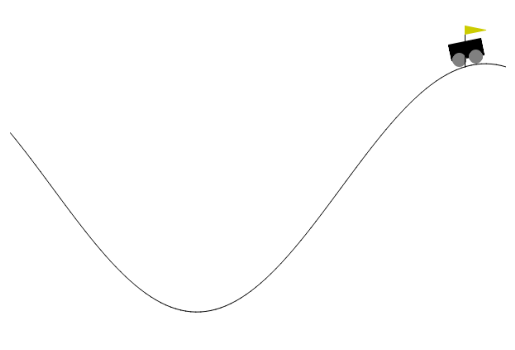

In [7]:
import gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

def visualize_model(render_mode, max_steps=10000, seed=42):
    # Initialize the environment with the given render mode
    env = gym.make("MountainCarContinuous-v0", render_mode=render_mode)
    
    # Set the seed for reproducibility
    state, info = env.reset(seed=seed)
    
    for episode in range(1):

        terminated = False
        truncated = False
        steps = 0
        
        while not (terminated or truncated) and steps < max_steps:
            # Choose an action using the agent
            action = select_action(state)
            # Take the action and get the next state and reward
            new_state, reward, terminated, truncated, info = env.step(action)
            state = new_state
            
            # Render the environment if in rgb_array mode for animation
            if render_mode == 'rgb_array':
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.axis('off')
                plt.show()
                
            steps += 1
        
        # Reset the environment for the next episode
        state, info = env.reset()
    
    # Close the environment
    env.close()

visualize_model(render_mode='rgb_array')
